# День 02 – Предиктивный анализ I

Наконец-то вы подошли уже вплотную к задаче, которая вам была поставлена неделю назад – разобраться с оттоком клиентов в банке, научившись его прогнозировать. Сегодня вы построите свою первую модель машинного обучения и построите прогноз по клиентам.

## 0. Импорт библиотек

В этот раз их тоже будет немало. К знакомым вам в этом блоке появляется библиотека seaborn, которая позволяет строить более красивые и сложные визуализации. Они нам потребуются.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_style("darkgrid") #у графиков будет красивая серая подложка

Также с этого дня вы начнете работать с библиотекой `scikit-learn`, в которой как раз много удобных функций и методов для машинного обучения и предобработки данных. Но ее мы будем добавлять точечно по ходу процесса анализа данных для большей наглядности. 

## 1. Загрузка данных

Сегодня наконец-то начнем работать с тем датасетом, который мы подготовили без пропущенных значений, с новыми столбцами, которые мы создали путем группировки непрерывных признаков.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/School21/day02/bank_data_train_d02.csv')

## 2. Демонстрация логистической регрессии

Прежде, чем вы начнете работать с датасетом и мы поделимся еще парой полезных команд, хочется продемонстрировать принцип работы логистической регрессии – одного из базовых алгоритмов машинного обучения.

Сделаем это на другом датасете, который больше подходит для целей демонстрации. Это датасет вин. Есть вина, произведенные на трех разных виноградниках. Нужно научиться определять какое вино относится к какому винограднику. Нашу задачу сократим для удобства до двух виноградников и только двух признаков: процент алкоголя и уровень пролина (аминокислота, входящая в состав вин).

In [ ]:
from sklearn.datasets import load_wine

In [ ]:
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df.insert(13, 'CLASS', data.target)
wine_two_classes = wine_df.loc[(wine_df.CLASS == 0) | (wine_df.CLASS == 1)]
wine_ready = wine_two_classes[['alcohol', 'proline', 'CLASS']]

In [ ]:
wine_ready.head(2)

,alcohol,proline,CLASS
0,14.23,1065.0,0
1,13.20,1050.0,0


Визуализируем распределение вин по уровню алкоголя и пролина при помощи диаграммы рассеяния и расскрасим точки в соответствии с виноградниками.

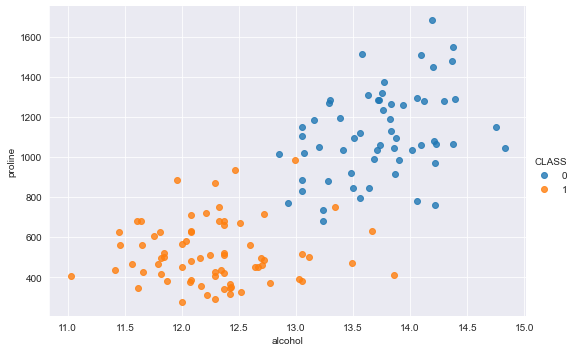

In [ ]:
sns.lmplot(x="alcohol", y="proline", data=wine_ready, fit_reg=False, hue='CLASS', legend=True,
          height=5, aspect=1.5)

Кажется, невооруженным взглядом видно, что виноградники производят отличающиеся группы вин. И можно придумать какое-то правило (или границу), по которой можно было провести отсечение: что вот всё, что тут, мы будем считать произведенным на первом винограднике, а всё, что там, мы будем считать – на втором винограднике.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = wine_ready[['alcohol', 'proline']]
y = wine_ready['CLASS']

In [ ]:
clf = LogisticRegression(random_state=21).fit(X, y) #обучим модель

In [ ]:
clf.coef_ #посмотрим на коэффициенты при получившейся регрессии

array([[-2.07000729, -0.01197466]])

Один коэффициент получился большим, а второй маленьким. Разница в 200 раз. Это может быть не очень хорошо. Проблема в том, что изначально наши признаки находились в разных шкалах по размеру. Лучше их привести в какую-то одну общую размерность.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X) #сделаем стандартизацию наших признаков

In [ ]:
X2[:5]

array([[ 1.452455  ,  0.782868  ],
       [ 0.28906609,  0.74015178],
       [ 0.24388594,  1.12459784],
       [ 1.61058554,  1.96468369],
       [ 0.33424624, -0.15688904]])

Как видно, признаки теперь у нас находятся примерно в одной какой-то шкале. Лог. регрессии будет теперь проще подобрать коэффициенты, которые при этом будут тоже примерно находится в одной размерности.

In [ ]:
clf2 = LogisticRegression(random_state=21).fit(X2, y)

In [ ]:
clf2.coef_

array([[-2.09192663, -2.4554651 ]])

Сейчас будет много кода для того, чтобы построить красивый график. Этот кусок кода вам в самостоятельной части не понадобится, поэтому можно на нем сильно не заострять внимание.

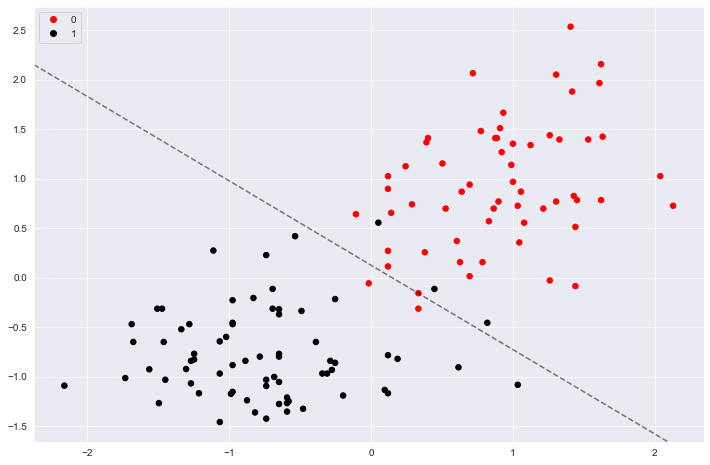

In [ ]:
plt.figure(figsize=(12,8))
a = plt.scatter(X2[:, 0], X2[:, 1], c=y, s=30, cmap='flag')

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf2.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.legend(handles=a.legend_elements()[0], labels=['0', '1'], loc='upper left')

Что сделала лог. регрессия? По сути в геометрическом смысле она предложила провести прямую линию, которая наилучшим образом отсекает точки двух классов. Всё, что ниже и левее этой линии считаем черными точками, а то, что правее и выше – красными. Да, правило неидеальное – местами есть ошибки: какие-то черные точки мы считаем красными, и наоборот. Но в общем и целом модель неплохо справилась с этим.

Давайте попробуем померить качество модели в каком-то числовом виде, а не только взглядом на график. Есть метрика `accuracy`, которая показывает % случаев, в которых модель верно угадала класс, по отношению к общему количеству наблюдений.

In [ ]:
clf2.score(X2, y) * 100

96.15384615384616

В 96% случаев модель справилась с предсказанием хорошо. Эта метрика может быть обманчивой, если у вас классы несбалансированы. Например, у вас и так 95% наблюдений – это один и тот же класс. Модель может просто все точки покрасить в один цвет сразу и получить высокий уровень качества, но на самом деле она справилась недостаточно хорошо. Про более сложные метрики поговорим завтра. Пока достаточно и этой.

## 3. Полезные команды

1. Сделать **one-hot encoding** для категориальных признаков.

In [ ]:
pd.get_dummies(df.APP_EDUCATION)

,a,ac,av,e,h,hh,hi,i,s,ss,uh,us,неизвестна
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355185,0,0,0,0,0,0,0,0,0,0,0,0,1
355186,0,0,0,0,0,0,0,0,0,0,0,0,1
355187,0,0,0,0,0,0,0,0,0,0,0,0,1
355188,0,0,0,0,0,0,0,0,0,0,0,0,1


2. **Разбить датасет** на train и test.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wine_ready[['alcohol', 'proline']], wine_ready.CLASS, 
                                                    test_size=0.2, random_state=21)

In [ ]:
X_train.head(2)

,alcohol,proline
87,11.65,562.0
55,13.56,1120.0


In [ ]:
X_test.head(2)

,alcohol,proline
19,13.64,845.0
42,13.88,1095.0


In [ ]:
y_train.head(2)

87    1
55    0
Name: CLASS, dtype: int64

In [ ]:
y_test.head(2)

19    0
42    0
Name: CLASS, dtype: int64

3. Функция, чтобы посмотреть на графике, **какие признаки** модель считает **наиболее важными** (у кого из них больше по модулю коэффициенты).

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

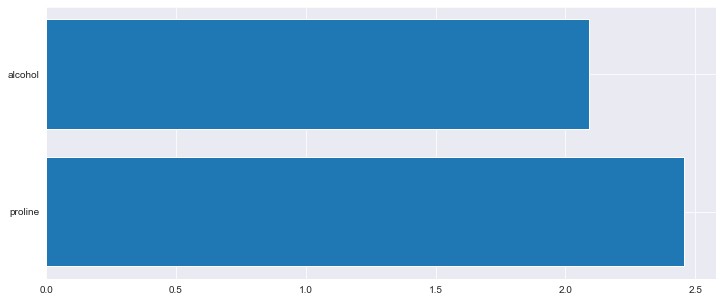

In [ ]:
f_importances(abs(clf2.coef_[0]), X_train.columns, top=2)

## 4. Самостоятельная часть

Ниже вам нужно самим по инструкции задания предобработать признаки и построить логистическую регрессию, которая спрогнозирует отток клиентов.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_style("darkgrid") #серая подложка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/School21/day02/bank_data_train_d02.csv', index_col='ID') #индекс

In [ ]:
df


,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,LDEAL_YQZ_COM_GROUP,LDEAL_YQZ_CHRG_GROUP,AVG_PCT_MONTH_TO_PCLOSE_GROUP,MAX_PCLOSE_DATE_GROUP,AVG_PCT_DEBT_TO_DEAL_AMT_GROUP,LDEAL_AMT_MONTH_GROUP,...,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
146841,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.593023,0.0,0.0,0.483032,0.406780,0.0,0.0,0.0,0.0,0
146842,0,0.041033,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.587647,0.0,0.0,0.394340,0.545455,0.0,0.0,0.0,0.0,0
146843,0,0.006915,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.587647,0.0,0.0,0.399342,0.297297,0.0,0.0,0.0,0.0,0
146844,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.583333,0.0,0.0,0.552169,0.558824,0.0,0.0,0.0,0.0,0
146845,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.583333,0.0,0.0,0.611610,0.620690,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.963872,0.0,0.0,0.659039,0.785714,0.0,0.0,0.0,0.0,0
590823,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.963872,0.0,0.0,0.652612,0.500000,0.0,0.0,0.0,0.0,0
590825,0,0.041298,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.966560,0.0,0.0,0.448386,0.459530,0.0,0.0,0.0,0.0,0


In [ ]:
df.drop(columns='CLNT_JOB_POSITION', inplace=True)#удаляем колонку

In [ ]:
df

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,LDEAL_YQZ_COM_GROUP,LDEAL_YQZ_CHRG_GROUP,AVG_PCT_MONTH_TO_PCLOSE_GROUP,MAX_PCLOSE_DATE_GROUP,AVG_PCT_DEBT_TO_DEAL_AMT_GROUP,LDEAL_AMT_MONTH_GROUP,...,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
146841,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.593023,0.0,0.0,0.483032,0.406780,0.0,0.0,0.0,0.0,0
146842,0,0.041033,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.587647,0.0,0.0,0.394340,0.545455,0.0,0.0,0.0,0.0,0
146843,0,0.006915,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.587647,0.0,0.0,0.399342,0.297297,0.0,0.0,0.0,0.0,0
146844,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.583333,0.0,0.0,0.552169,0.558824,0.0,0.0,0.0,0.0,0
146845,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,1.583333,0.0,0.0,0.611610,0.620690,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.963872,0.0,0.0,0.659039,0.785714,0.0,0.0,0.0,0.0,0
590823,0,0.000000,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.963872,0.0,0.0,0.652612,0.500000,0.0,0.0,0.0,0.0,0
590825,0,0.041298,неизвестна,0.0,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,8.966560,0.0,0.0,0.448386,0.459530,0.0,0.0,0.0,0.0,0


In [ ]:
df_num = df.select_dtypes(include=['int64', 'float64'] )#количественные столбцы
df_num.drop(columns='TARGET', inplace=True)#удаляем колонку

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_num

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,TURNOVER_DYNAMIC_CUR_3M,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M
ID,,,,,,,,,,,,,,,,,,,,,
146841,0,0.000000,0.0,0.000000,0.0,0.541683,0,156067.339767,0.000000,0.000000,...,0.442285,1.593023,0.0,0.0,0.483032,0.406780,0.0,0.0,0.0,0.0
146842,0,0.041033,0.0,0.244678,0.0,0.000000,0,4278.845817,0.000000,0.454545,...,0.515876,1.587647,0.0,0.0,0.394340,0.545455,0.0,0.0,0.0,0.0
146843,0,0.006915,0.0,0.000000,0.0,0.000000,0,112837.062817,0.000000,0.000000,...,0.522833,1.587647,0.0,0.0,0.399342,0.297297,0.0,0.0,0.0,0.0
146844,0,0.000000,0.0,0.000000,0.0,0.005874,0,42902.902883,0.000000,0.000000,...,0.000189,1.583333,0.0,0.0,0.552169,0.558824,0.0,0.0,0.0,0.0
146845,0,0.000000,0.0,0.000000,0.0,0.000000,0,71906.476533,0.000000,0.000000,...,0.593648,1.583333,0.0,0.0,0.611610,0.620690,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,0,0.000000,0.0,0.000000,0.0,0.000000,0,9697.620867,0.000000,0.000000,...,0.572322,8.963872,0.0,0.0,0.659039,0.785714,0.0,0.0,0.0,0.0
590823,0,0.000000,0.0,0.000000,0.0,0.000000,0,428380.024733,0.262714,0.000000,...,0.392381,8.963872,0.0,0.0,0.652612,0.500000,0.0,0.0,0.0,0.0
590825,0,0.041298,0.0,0.095187,0.0,0.000000,0,224884.436700,0.031179,0.211488,...,0.447377,8.966560,0.0,0.0,0.448386,0.459530,0.0,0.0,0.0,0.0


In [ ]:
df.describe()

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M,TARGET
count,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,3.551900e+05,355190.000000,355190.000000,...,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000
mean,0.105225,0.039293,0.001305,0.078977,0.000723,0.063400,0.031214,6.635854e+04,0.021384,0.186310,...,4.377001,0.071906,0.025108,0.577835,0.591622,0.002191,0.000883,0.007309,0.004309,0.081435
std,0.431372,0.103339,0.029118,0.135618,0.014081,0.202963,0.184059,1.878598e+05,0.086059,0.185457,...,2.936530,0.206863,0.104482,0.260904,0.228731,0.026360,0.027321,0.066681,0.059852,0.273503
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.345592,0.000000,0.000000,0.000000,0.005747,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.070440e+03,0.000000,0.000000,...,1.781187,0.000000,0.000000,0.417991,0.455882,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.027117,0.000000,0.000000,0.000000,1.628925e+04,0.000000,0.147059,...,3.894098,0.000000,0.000000,0.552169,0.558824,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.028539,0.000000,0.095284,0.000000,0.000000,0.000000,5.659516e+04,0.007976,0.285714,...,6.555388,0.000000,0.000000,0.750901,0.713043,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.202141e+07,1.000000,1.000000,...,13.748937,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
df_stand = df_num.copy()
df_stand[df_num.columns] = scaler.fit_transform(df_num) #сделаем стандартизацию наших признаков
df_stand

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,TURNOVER_DYNAMIC_CUR_3M,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M
ID,,,,,,,,,,,,,,,,,,,,,
146841,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,2.356500,-0.169589,0.477531,-0.248485,-1.004598,...,-0.128283,-0.948052,-0.347604,-0.240313,-0.363365,-0.808123,-0.083103,-0.032303,-0.109613,-0.071988
146842,-0.243932,0.016835,-0.044824,1.221828,-0.05133,-0.312371,-0.169589,-0.330458,-0.248485,1.446347,...,0.093638,-0.949882,-0.347604,-0.240313,-0.703305,-0.201842,-0.083103,-0.032303,-0.109613,-0.071988
146843,-0.243932,-0.313313,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,0.247411,-0.248485,-1.004598,...,0.114617,-0.949882,-0.347604,-0.240313,-0.684133,-1.286775,-0.083103,-0.032303,-0.109613,-0.071988
146844,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.283428,-0.169589,-0.124857,-0.248485,-1.004598,...,-1.461483,-0.951351,-0.347604,-0.240313,-0.098373,-0.143394,-0.083103,-0.032303,-0.109613,-0.071988
146845,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,0.029532,-0.248485,-1.004598,...,0.328171,-0.951351,-0.347604,-0.240313,0.129454,0.127082,-0.083103,-0.032303,-0.109613,-0.071988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.301613,-0.248485,-1.004598,...,0.263860,1.562006,-0.347604,-0.240313,0.311241,0.848562,-0.083103,-0.032303,-0.109613,-0.071988
590823,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,1.927086,2.804227,-1.004598,...,-0.278776,1.562006,-0.347604,-0.240313,0.286606,-0.400568,-0.083103,-0.032303,-0.109613,-0.071988
590825,-0.243932,0.019401,-0.044824,0.119528,-0.05133,-0.312371,-0.169589,0.843853,0.113815,0.135764,...,-0.112929,1.562922,-0.347604,-0.240313,-0.496155,-0.577500,-0.083103,-0.032303,-0.109613,-0.071988


In [ ]:
df_stand.describe()

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,TURNOVER_DYNAMIC_CUR_3M,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M
count,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,...,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05,3.551900e+05
mean,3.464794e-17,8.391922e-17,-1.880431e-18,2.716622e-17,1.120257e-18,-6.141407e-18,-2.612598e-17,-1.227081e-16,9.002062e-17,-3.044697e-17,...,-6.649523e-17,-9.042071e-16,-5.361228e-18,-5.247202e-17,-3.626431e-16,-3.345566e-16,-1.916439e-17,-1.221780e-17,2.083477e-17,6.041384e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.439322e-01,-3.802316e-01,-4.482367e-02,-5.823467e-01,-5.133023e-02,-3.123713e-01,-1.695891e-01,-3.532350e-01,-2.484846e-01,-1.004598e+00,...,-1.462053e+00,-1.372850e+00,-3.476041e-01,-2.403127e-01,-2.214741e+00,-2.561419e+00,-8.310275e-02,-3.230285e-02,-1.096131e-01,-7.198831e-02
25%,-2.439322e-01,-3.802316e-01,-4.482367e-02,-5.823467e-01,-5.133023e-02,-3.123713e-01,-1.695891e-01,-3.315675e-01,-2.484846e-01,-1.004598e+00,...,-8.028891e-01,-8.839744e-01,-3.476041e-01,-2.403127e-01,-6.126564e-01,-5.934479e-01,-8.310275e-02,-3.230285e-02,-1.096131e-01,-7.198831e-02
50%,-2.439322e-01,-3.802316e-01,-4.482367e-02,-3.823977e-01,-5.133023e-02,-3.123713e-01,-1.695891e-01,-2.665252e-01,-2.484846e-01,-2.116449e-01,...,2.879020e-02,-1.644469e-01,-3.476041e-01,-2.403127e-01,-9.837331e-02,-1.433938e-01,-8.310275e-02,-3.230285e-02,-1.096131e-01,-7.198831e-02
75%,-2.439322e-01,-1.040664e-01,-4.482367e-02,1.202470e-01,-5.133023e-02,-3.123713e-01,-1.695891e-01,-5.197172e-02,-1.558030e-01,5.359964e-01,...,7.299314e-01,7.418248e-01,-3.476041e-01,-2.403127e-01,6.633307e-01,5.308489e-01,-8.310275e-02,-3.230285e-02,-1.096131e-01,-7.198831e-02
max,2.525614e+01,9.296631e+00,3.429880e+01,6.791310e+00,7.096700e+01,4.614631e+00,2.156266e+01,1.168695e+02,1.137141e+01,4.387482e+00,...,1.553578e+00,3.191505e+00,4.486527e+00,9.330759e+00,1.618084e+00,1.785410e+00,3.785256e+01,3.656921e+01,1.488724e+01,1.663590e+01


In [ ]:
df_obj = df.select_dtypes(include='object')

In [ ]:
df_obj

,APP_REGISTR_RGN_CODE,LDEAL_YQZ_COM_GROUP,LDEAL_YQZ_CHRG_GROUP,AVG_PCT_MONTH_TO_PCLOSE_GROUP,MAX_PCLOSE_DATE_GROUP,AVG_PCT_DEBT_TO_DEAL_AMT_GROUP,LDEAL_AMT_MONTH_GROUP,LDEAL_YQZ_PC_GROUP,LDEAL_DELINQ_PER_MAXYQZ_GROUP,MED_DEBT_PRC_YQZ_GROUP,...,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,PACK
ID,,,,,,,,,,,,,,,,,,,,,
146841,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,k01
146842,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,102
146843,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,102
146844,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,k01
146845,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,104
590823,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,104
590825,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,...,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,неизвестна,k01


In [ ]:
sum(df_obj.nunique())

323

In [ ]:
df_obj_dummies = pd.get_dummies(df_obj)
df_obj_dummies

,APP_REGISTR_RGN_CODE_1,APP_REGISTR_RGN_CODE_10,APP_REGISTR_RGN_CODE_11,APP_REGISTR_RGN_CODE_12,APP_REGISTR_RGN_CODE_13,APP_REGISTR_RGN_CODE_14,APP_REGISTR_RGN_CODE_15,APP_REGISTR_RGN_CODE_16,APP_REGISTR_RGN_CODE_17,APP_REGISTR_RGN_CODE_18,...,PACK_103,PACK_104,PACK_105,PACK_107,PACK_108,PACK_109,PACK_301,PACK_k01,PACK_m01,PACK_o01
ID,,,,,,,,,,,,,,,,,,,,,
146841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
146842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
146845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
590823,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
590825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_preprocessed = df_obj_dummies.merge(df_stand, left_on="ID",right_on="ID")
df_preprocessed['TARGET'] = df['TARGET']
df_preprocessed

,APP_REGISTR_RGN_CODE_1,APP_REGISTR_RGN_CODE_10,APP_REGISTR_RGN_CODE_11,APP_REGISTR_RGN_CODE_12,APP_REGISTR_RGN_CODE_13,APP_REGISTR_RGN_CODE_14,APP_REGISTR_RGN_CODE_15,APP_REGISTR_RGN_CODE_16,APP_REGISTR_RGN_CODE_17,APP_REGISTR_RGN_CODE_18,...,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
146841,0,0,0,0,0,0,0,0,0,0,...,-0.948052,-0.347604,-0.240313,-0.363365,-0.808123,-0.083103,-0.032303,-0.109613,-0.071988,0
146842,0,0,0,0,0,0,0,0,0,0,...,-0.949882,-0.347604,-0.240313,-0.703305,-0.201842,-0.083103,-0.032303,-0.109613,-0.071988,0
146843,0,0,0,0,0,0,0,0,0,0,...,-0.949882,-0.347604,-0.240313,-0.684133,-1.286775,-0.083103,-0.032303,-0.109613,-0.071988,0
146844,0,0,0,0,0,0,0,0,0,0,...,-0.951351,-0.347604,-0.240313,-0.098373,-0.143394,-0.083103,-0.032303,-0.109613,-0.071988,0
146845,0,0,0,0,0,0,0,0,0,0,...,-0.951351,-0.347604,-0.240313,0.129454,0.127082,-0.083103,-0.032303,-0.109613,-0.071988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590822,0,0,0,0,0,0,0,0,0,0,...,1.562006,-0.347604,-0.240313,0.311241,0.848562,-0.083103,-0.032303,-0.109613,-0.071988,0
590823,0,0,0,0,0,0,0,0,0,0,...,1.562006,-0.347604,-0.240313,0.286606,-0.400568,-0.083103,-0.032303,-0.109613,-0.071988,0
590825,0,0,0,0,0,0,0,0,0,0,...,1.562922,-0.347604,-0.240313,-0.496155,-0.577500,-0.083103,-0.032303,-0.109613,-0.071988,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed.drop('TARGET', axis=1),
                                                    df_preprocessed['TARGET'],
                                                    test_size=0.2, random_state=21)

In [ ]:
X_train

,APP_REGISTR_RGN_CODE_1,APP_REGISTR_RGN_CODE_10,APP_REGISTR_RGN_CODE_11,APP_REGISTR_RGN_CODE_12,APP_REGISTR_RGN_CODE_13,APP_REGISTR_RGN_CODE_14,APP_REGISTR_RGN_CODE_15,APP_REGISTR_RGN_CODE_16,APP_REGISTR_RGN_CODE_17,APP_REGISTR_RGN_CODE_18,...,TURNOVER_DYNAMIC_CUR_3M,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M
ID,,,,,,,,,,,,,,,,,,,,,
160587,0,0,0,0,0,0,0,0,0,0,...,-1.460470,-1.122898,-0.347604,-0.240313,-0.098373,-0.143394,-0.083103,-0.032303,-0.109613,-0.071988
328947,0,0,0,0,0,0,0,1,0,0,...,0.103343,1.199535,-0.347604,-0.240313,0.725068,0.490016,-0.083103,-0.032303,-0.109613,-0.071988
583619,0,0,0,0,0,0,0,0,0,0,...,0.620571,1.197667,-0.347604,-0.240313,-0.429915,-0.488007,-0.083103,-0.032303,-0.109613,-0.071988
155922,0,0,0,0,0,0,0,0,0,0,...,-1.462053,1.872376,1.293528,0.304868,-1.244397,-1.096106,-0.083103,-0.032303,-0.109613,-0.071988
468688,0,0,0,0,0,0,0,0,0,0,...,0.496767,-1.208988,-0.347604,-0.240313,-0.098373,-0.143394,-0.083103,-0.032303,-0.109613,-0.071988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249311,0,0,0,0,0,0,0,0,0,0,...,0.242155,-0.113183,-0.347604,-0.240313,0.108183,-0.837763,-0.083103,-0.032303,-0.109613,-0.071988
321783,0,0,0,0,0,0,0,0,0,0,...,-0.224032,-1.184234,-0.347604,-0.240313,-0.632199,-0.786328,-0.083103,-0.032303,-0.109613,-0.071988
399839,0,0,0,0,0,0,0,0,0,0,...,0.327975,-0.399714,-0.347604,-0.240313,-0.019930,-0.201842,-0.083103,-0.032303,-0.109613,-0.071988


In [ ]:
X_test

,APP_REGISTR_RGN_CODE_1,APP_REGISTR_RGN_CODE_10,APP_REGISTR_RGN_CODE_11,APP_REGISTR_RGN_CODE_12,APP_REGISTR_RGN_CODE_13,APP_REGISTR_RGN_CODE_14,APP_REGISTR_RGN_CODE_15,APP_REGISTR_RGN_CODE_16,APP_REGISTR_RGN_CODE_17,APP_REGISTR_RGN_CODE_18,...,TURNOVER_DYNAMIC_CUR_3M,CLNT_SETUP_TENOR,TURNOVER_DYNAMIC_PAYM_3M,TURNOVER_DYNAMIC_PAYM_1M,TRANS_AMOUNT_TENDENCY3M,TRANS_CNT_TENDENCY3M,REST_DYNAMIC_CC_1M,TURNOVER_DYNAMIC_CC_1M,REST_DYNAMIC_CC_3M,TURNOVER_DYNAMIC_CC_3M
ID,,,,,,,,,,,,,,,,,,,,,
213012,0,0,0,0,0,0,0,0,0,0,...,-1.462053,1.277349,3.623738,2.395291,-0.259415,-2.321578,-0.083103,-0.032303,-0.109613,-0.071988
425165,0,0,0,0,0,0,0,0,0,0,...,-1.345317,-0.649625,-0.347604,-0.240313,-0.098373,-0.143394,-0.083103,-0.032303,-0.109613,-0.071988
418831,0,0,0,0,0,0,0,0,0,0,...,-0.568888,-1.159518,-0.347604,-0.240313,-0.976199,-0.466809,-0.083103,-0.032303,-0.109613,-0.071988
309967,0,0,0,0,0,0,0,0,0,0,...,-1.462053,0.505642,1.723156,0.690565,0.367850,-0.305525,-0.083103,-0.032303,-0.109613,-0.071988
541027,0,0,0,0,0,0,0,0,0,0,...,0.082379,-0.679872,-0.347604,-0.240313,-0.239308,-1.176237,-0.083103,-0.032303,-0.109613,-0.071988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582743,0,0,0,0,0,0,0,0,0,0,...,0.045763,-1.008108,-0.347604,-0.240313,-0.298328,0.328092,-0.083103,-0.032303,-0.109613,-0.071988
261292,0,0,0,0,0,0,0,0,0,0,...,-0.196068,1.340513,-0.347604,-0.240313,-0.000232,0.328092,-0.083103,-0.032303,-0.109613,-0.071988
180844,0,0,0,0,0,0,0,0,0,0,...,0.131662,1.310304,-0.347604,-0.240313,-0.761273,-0.552071,-0.083103,-0.032303,-0.109613,-0.071988


In [ ]:
y_train

ID
160587    0
328947    0
583619    0
155922    0
468688    0
         ..
249311    0
321783    1
399839    0
563123    0
247886    0
Name: TARGET, Length: 284152, dtype: int64

In [ ]:
y_test

ID
213012    0
425165    0
418831    1
309967    0
541027    0
         ..
582743    1
261292    0
180844    0
283693    0
238505    0
Name: TARGET, Length: 71038, dtype: int64

In [ ]:
clf = LogisticRegression(solver='liblinear', fit_intercept=False, penalty='l1', random_state=21)

In [ ]:
clf.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, penalty='l1', random_state=21,
                   solver='liblinear')

In [ ]:
clf.predict_proba(X_test)

array([[8.83594521e-01, 1.16405479e-01],
       [8.07831364e-01, 1.92168636e-01],
       [9.09336357e-01, 9.06636426e-02],
       ...,
       [9.99934869e-01, 6.51312283e-05],
       [9.03892611e-01, 9.61073889e-02],
       [9.86739787e-01, 1.32602131e-02]])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9197331005940482

In [ ]:
sum(y_test == y_pred)/len(y_test)

0.9197331005940482

In [ ]:
sum(y_test == 0) / y_test.size * 100 #не сбалансирован

91.96064078380584

In [ ]:
sns.set_style("darkgrid")

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

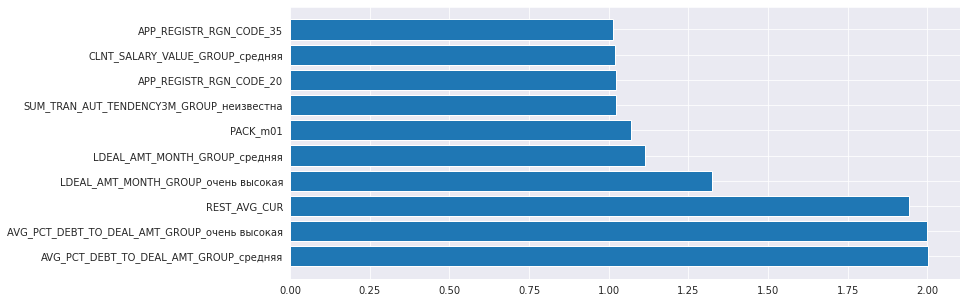

In [ ]:
f_importances(abs(clf.coef_[0]), X_train.columns, top=10)